## 눈 이미지를 사용해서 봄여름가을겨울을 나누는 딥러닝 시작.

In [ ]:
# pip install torch torchvision torchaudio
# pip install efficientnet_pytorch
# pip install albumentations

In [1]:
import re
import glob
import matplotlib.pyplot as plt
import dlib
import cv2
import numpy as np
import os
import shutil
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
# from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action='ignore')
import random

In [2]:
import pandas as pd
import os.path
import seaborn as sns

from pathlib import Path
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display
from sklearn import preprocessing



In [3]:
# base_path = 'C:/Users/jungh/final_project/img_path/eye_path'

In [5]:
# # 데이터 전처리와 전처리한 데이터를 저장하기 위해 사용
# for root, dirs, files in os.walk(base_path): # os.walk()를 사용하면 모든 하위 폴더와 파일을 탐색 할 수 있다  하위의 폴더들을 for문으로 탐색할 수 있게 해줌
#     for file in files:
#         if file.lower().endswith('.jpg') or file.lower().endswith('.jpeg'):
#             image_path = os.path.join(root, file)

#             # 이미지 변환 코드
#             eye = cv2.imread(image_path)
#             eye_gray = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)
#             _, thresholded = cv2.threshold(eye_gray, 90, 255, cv2.THRESH_BINARY)
#             thresholded = cv2.inRange(thresholded, 0, 1)
#             eye_masked = cv2.bitwise_and(eye, eye, mask=thresholded)

#             # 이미지 저장 코드
#             output_dir = os.path.join(root, 'processed')
#             os.makedirs(output_dir, exist_ok=True)
#             output_path = os.path.join(output_dir, file)
#             cv2.imwrite(output_path, eye_masked)

In [2]:
# 하이퍼파라미터 설정
learning_rate = 0.0001
batch_size = 20
num_epochs = 30
SEED = 42

In [3]:
# 데이터셋 경로
data_path = 'C:/Users/jungh/final_project/eye_deeplearning'
classes = ['spring', 'summer', 'fall', 'winter']
num_classes = len(classes)
image_size = (64, 64)

## Model1

In [307]:
class CustomDataset(Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels
    
  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]
    
    return image, label

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(32 * (image_size[0] // 2) * (image_size[1] // 2), 64)
    self.fc2 = nn.Linear(64, num_classes)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    
    return x
  


In [308]:
def load_dataset():
  x = []
  y = []
  
  for i, class_name in enumerate(classes):
    class_path = os.path.join(data_path, class_name)
    for image_name in os.listdir(class_path):
      image_path = os.path.join(class_path, image_name)
      image = cv2.imread(image_path)
      image = cv2.resize(image, image_size)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      x.append(image)
      y.append(i)
  
  x = np.array(x)
  y = np.array(y)
  
  return x, y
    


In [309]:
# 테스트용
def load_dataset():
  x = []
  y = []
  
  for i, class_name in enumerate(classes):
    class_path = os.path.join(data_path, class_name)
    for image_name in os.listdir(class_path):
      image_path = os.path.join(class_path, image_name)
      image = cv2.imread(image_path, cv2.IMREAD_COLOR)
      image = cv2.resize(image, image_size)
      x.append(image)
      y.append(i)
  
  x = np.array(x)
  y = np.array(y)
  
  return x, y
    


In [310]:
x, y = load_dataset()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=SEED)

x_train = x_train.reshape(-1, 3, image_size[0], image_size[1])
x_test = x_test.reshape(-1, 3, image_size[0], image_size[1])

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [312]:
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel().float().to(device)
model.conv1 = nn.Conv2d(x.shape[3], 32, kernel_size=3, stride=1, padding=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [314]:
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  
  
  with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as progress_bar:
    for images, labels in train_dataloader:
      images = images.float().to(device)
      labels = labels.to(device)
      
      outputs = model(images)
      loss = criterion(outputs, labels)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
      progress_bar.set_postfix(loss=running_loss / (len(train_dataloader)))
      progress_bar.update()
            
  

Epoch 30/30: 100%|██████████| 63/63 [00:07<00:00,  8.54batch/s, loss=0.189] 


In [316]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in test_dataloader:
    images = images.float().to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    

accuracy = 100 * correct / total 


In [317]:
accuracy

31.528662420382165

## Model2 (정확도 30.254777070063696)

In [ ]:
# 하이퍼파라미터 설정
learning_rate = 0.0001
batch_size = 20
num_epochs = 30
SEED = 42

In [ ]:
# 데이터셋 경로
data_path = 'C:/Users/jungh/final_project/eye_deeplearning'
classes = ['spring', 'summer', 'fall', 'winter']
num_classes = len(classes)
image_size = (64, 64)

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels
    
  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]
    
    return image, label

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(64 * (image_size[0] // 4) * (image_size[1] // 4), 64)
    self.bn3 = nn.BatchNorm1d(64)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(64, num_classes)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.bn3(x)
    x = self.relu3(x)
    x = self.fc2(x)
    return x
  


In [ ]:
# 테스트용
def load_dataset():
  x = []
  y = []
  
  for i, class_name in enumerate(classes):
    class_path = os.path.join(data_path, class_name)
    for image_name in os.listdir(class_path):
      image_path = os.path.join(class_path, image_name)
      image = cv2.imread(image_path, cv2.IMREAD_COLOR)
      image = cv2.resize(image, image_size)
      x.append(image)
      y.append(i)
  
  x = np.array(x)
  y = np.array(y)
  
  return x, y
    


In [ ]:
x, y = load_dataset()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=SEED, stratify=y)

x_train = x_train.reshape(-1, 3, image_size[0], image_size[1])
x_test = x_test.reshape(-1, 3, image_size[0], image_size[1])

# 텐서로 변환
x_train = torch.from_numpy(x_train).float() / 255.0
x_test = torch.from_numpy(x_test).float() / 255.0

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [ ]:
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel().float().to(device)
model.conv1 = nn.Conv2d(x.shape[3], 32, kernel_size=3, stride=1, padding=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  
  
  with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as progress_bar:
    for images, labels in train_dataloader:
      images = images.float().to(device)
      labels = labels.to(device)
      
      outputs = model(images)
      loss = criterion(outputs, labels)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
      progress_bar.set_postfix(loss=running_loss / (len(train_dataloader)))
      progress_bar.update()
            
  

In [ ]:
running_loss

1.8746503675356507

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in test_dataloader:
    images = images.float().to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    

accuracy = 100 * correct / total 


## Model3

## 러닝레이트 0.0001 에폭 30 배치 20으로 햇을때 61.5퍼나옴

In [4]:
# 하이퍼파라미터 설정
learning_rate = 0.001
batch_size = 20
num_epochs = 50
SEED = 42

In [5]:
# 데이터셋 경로
data_path = 'C:/Users/jungh/final_project/eye_deeplearning'
classes = ['spring', 'summer', 'fall', 'winter']
num_classes = len(classes)
image_size = (64, 64)

In [6]:
class CustomDataset(Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels
    
  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]
    
    return image, label

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(64 * (image_size[0] // 4) * (image_size[1] // 4), 64)
    self.bn3 = nn.BatchNorm1d(64)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(64, num_classes)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.bn3(x)
    x = self.relu3(x)
    x = self.fc2(x)
    return x
  


In [7]:

def load_dataset():
  x = []
  y = []
  
  for i, class_name in enumerate(classes):
    class_path = os.path.join(data_path, class_name)
    for image_name in os.listdir(class_path):
      image_path = os.path.join(class_path, image_name)
      image = cv2.imread(image_path)
      image = cv2.resize(image, image_size)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      x.append(image)
      y.append(i)
  
  x = np.array(x)
  y = np.array(y)
  
  return x, y
    


In [8]:
x, y = load_dataset()
# 데이터셋을 훈련 세트와 임시 데이터로 분할 (비율: 80% 훈련, 20% 임시 데이터)
x_train_temp, x_test, y_train_temp, y_test = train_test_split(x, y, test_size = 0.2, random_state=SEED, stratify=y)

# 임시 데이터를 다시 훈련 세트와 검증 세트로 분할 (비율: 75% 훈련, 25% 검증)
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.25, random_state=SEED, stratify=y_train_temp)

x_train = x_train.reshape(-1, 3, image_size[0], image_size[1])
x_val = x_val.reshape(-1, 3, image_size[0], image_size[1])
x_test = x_test.reshape(-1, 3, image_size[0], image_size[1])

# 텐서로 변환
x_train = torch.from_numpy(x_train).float() / 255.0
x_val = torch.from_numpy(x_val).float() / 255.0
x_test = torch.from_numpy(x_test).float() / 255.0

y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)
y_test = torch.LongTensor(y_test)

In [9]:
train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)
test_dataset = CustomDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel().float().to(device)
model.conv1 = nn.Conv2d(x.shape[3], 32, kernel_size=3, stride=1, padding=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
best_val_accuracy = 0.0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = [] 
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  correct_train = 0
  total_train = 0  
  
  with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as progress_bar:
    for images, labels in train_dataloader:
      images = images.float().to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
      progress_bar.set_postfix(loss=running_loss / (len(train_dataloader)))
      progress_bar.update()
      _, predicted_train = torch.max(outputs.data, 1)
      total_train += labels.size(0)
      correct_train += (predicted_train == labels).sum().item()
  epoch_loss = running_loss / len(train_dataloader)
  train_losses.append(epoch_loss)              
  train_accuracy = 100 * correct_train / total_train
  train_accuracies.append(train_accuracy)
  
  model.eval()
  correct = 0
  total = 0
  val_loss = 0.0

  
  
  with torch.no_grad():
    for images, labels in val_dataloader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item() 
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  val_accuracy = 100 * correct / total
  val_loss /= len(val_dataloader)
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)
  print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# 검증 세트의 정확도가 이전에 기록한 최고 정확도보다 높으면 모델 저장
  if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      torch.save(model.state_dict(), 'best_model.pt')

Epoch 1/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 1/50: Train Loss: 1.4182, Val Accuracy: 31.21%


Epoch 2/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 2/50: Train Loss: 1.2996, Val Accuracy: 28.23%


Epoch 3/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 3/50: Train Loss: 1.2135, Val Accuracy: 29.22%


Epoch 4/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 4/50: Train Loss: 1.0686, Val Accuracy: 30.02%


Epoch 5/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 5/50: Train Loss: 0.9298, Val Accuracy: 27.83%


Epoch 6/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 6/50: Train Loss: 0.7195, Val Accuracy: 26.84%


Epoch 7/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 7/50: Train Loss: 0.5083, Val Accuracy: 29.22%


Epoch 8/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 8/50: Train Loss: 0.3468, Val Accuracy: 29.22%


Epoch 9/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 9/50: Train Loss: 0.2486, Val Accuracy: 30.22%


Epoch 10/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 10/50: Train Loss: 0.1452, Val Accuracy: 31.81%


Epoch 11/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 11/50: Train Loss: 0.0988, Val Accuracy: 28.83%


Epoch 12/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 12/50: Train Loss: 0.0623, Val Accuracy: 31.01%


Epoch 13/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 13/50: Train Loss: 0.0641, Val Accuracy: 31.01%


Epoch 14/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 14/50: Train Loss: 0.0443, Val Accuracy: 31.01%


Epoch 15/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 15/50: Train Loss: 0.0527, Val Accuracy: 28.83%


Epoch 16/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 16/50: Train Loss: 0.0486, Val Accuracy: 29.22%


Epoch 17/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 17/50: Train Loss: 0.0475, Val Accuracy: 31.21%


Epoch 18/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 18/50: Train Loss: 0.0774, Val Accuracy: 31.01%


Epoch 19/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 19/50: Train Loss: 0.0913, Val Accuracy: 32.41%


Epoch 20/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 20/50: Train Loss: 0.0999, Val Accuracy: 31.81%


Epoch 21/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 21/50: Train Loss: 0.0828, Val Accuracy: 29.82%


Epoch 22/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 22/50: Train Loss: 0.0740, Val Accuracy: 29.03%


Epoch 23/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 23/50: Train Loss: 0.0688, Val Accuracy: 30.62%


Epoch 24/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 24/50: Train Loss: 0.0430, Val Accuracy: 29.42%


Epoch 25/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 25/50: Train Loss: 0.0583, Val Accuracy: 31.81%


Epoch 26/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 26/50: Train Loss: 0.0299, Val Accuracy: 31.41%


Epoch 27/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 27/50: Train Loss: 0.0372, Val Accuracy: 29.82%


Epoch 28/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 28/50: Train Loss: 0.0490, Val Accuracy: 31.41%


Epoch 29/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 29/50: Train Loss: 0.0496, Val Accuracy: 31.61%


Epoch 30/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 30/50: Train Loss: 0.0237, Val Accuracy: 30.22%


Epoch 31/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 31/50: Train Loss: 0.0151, Val Accuracy: 30.82%


Epoch 32/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 32/50: Train Loss: 0.0097, Val Accuracy: 31.01%


Epoch 33/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 33/50: Train Loss: 0.0123, Val Accuracy: 32.01%


Epoch 34/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 34/50: Train Loss: 0.0231, Val Accuracy: 30.22%


Epoch 35/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 35/50: Train Loss: 0.0499, Val Accuracy: 29.22%


Epoch 36/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 36/50: Train Loss: 0.0472, Val Accuracy: 32.41%


Epoch 37/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 37/50: Train Loss: 0.0422, Val Accuracy: 29.82%


Epoch 38/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 38/50: Train Loss: 0.0266, Val Accuracy: 31.01%


Epoch 39/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 39/50: Train Loss: 0.0332, Val Accuracy: 31.61%


Epoch 40/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 40/50: Train Loss: 0.0398, Val Accuracy: 33.80%


Epoch 41/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 41/50: Train Loss: 0.0330, Val Accuracy: 32.80%


Epoch 42/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 42/50: Train Loss: 0.0303, Val Accuracy: 31.01%


Epoch 43/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 43/50: Train Loss: 0.0169, Val Accuracy: 33.00%


Epoch 44/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 44/50: Train Loss: 0.0162, Val Accuracy: 30.82%


Epoch 45/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 45/50: Train Loss: 0.0195, Val Accuracy: 31.21%


Epoch 46/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 46/50: Train Loss: 0.0270, Val Accuracy: 32.80%


Epoch 47/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 47/50: Train Loss: 0.0254, Val Accuracy: 31.01%


Epoch 48/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 48/50: Train Loss: 0.0303, Val Accuracy: 31.21%


Epoch 49/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 49/50: Train Loss: 0.0379, Val Accuracy: 30.42%


Epoch 50/50:   0%|          | 0/76 [00:00<?, ?batch/s]

Epoch 50/50: Train Loss: 0.0514, Val Accuracy: 28.83%


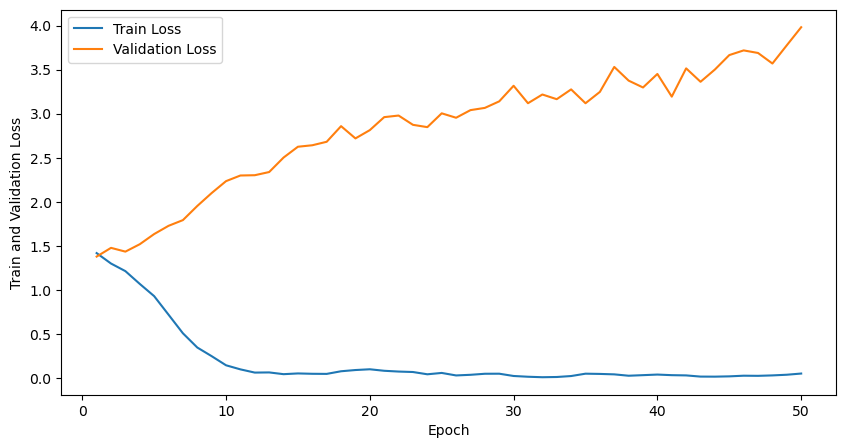

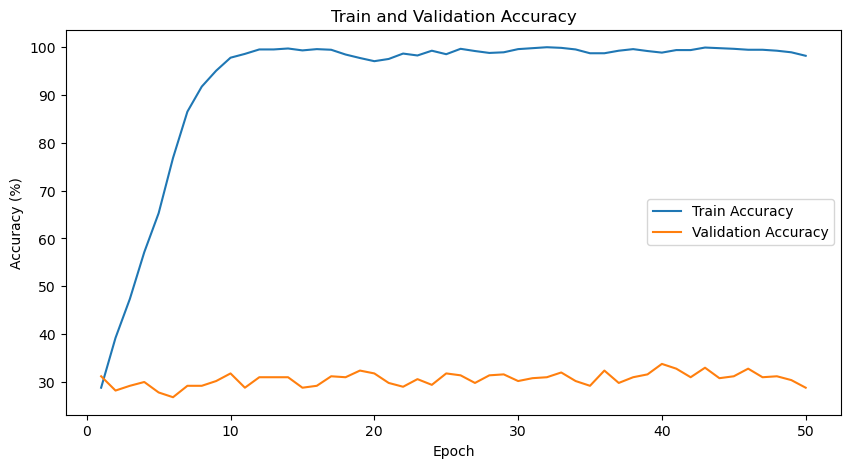

In [11]:
# 훈련 정확도와 검증 정확도 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Train and Validation Loss')
plt.legend()
plt.show()

# 훈련 정확도와 검증 정확도 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train and Validation Accuracy")
plt.legend()
plt.show()

In [41]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
coreerct = 0
total = 0

In [42]:
with torch.no_grad():
  for images, labels in test_dataloader:
    images = images.float().to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    

test_accuracy = 100 * correct / total 
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 59.33%


## Model4

## 모델의 복잡성을 늘려보았으나 오히려 정확도가 떨어짐  57퍼

In [46]:
# 하이퍼파라미터 설정
learning_rate = 0.001
batch_size = 20
num_epochs = 50
SEED = 42

In [47]:
import torch.nn.functional as F

In [48]:
# 데이터셋 경로
data_path = 'C:/Users/jungh/final_project/eye_deeplearning'
classes = ['spring', 'summer', 'fall', 'winter']
num_classes = len(classes)
image_size = (64, 64)

In [49]:
class CustomDataset(Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels
    
  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]
    
    return image, label

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU()
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.relu3 = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(128 * (image_size[0] // 8) * (image_size[1] // 8), 256)
    self.bn4 = nn.BatchNorm1d(256)
    self.relu4 = nn.ReLU()
    self.fc2 = nn.Linear(256, num_classes)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    x = self.maxpool(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu3(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.bn4(x)
    x = self.relu4(x)
    x = self.fc2(x)
    return x
  


In [50]:

def load_dataset():
  x = []
  y = []
  
  for i, class_name in enumerate(classes):
    class_path = os.path.join(data_path, class_name)
    for image_name in os.listdir(class_path):
      image_path = os.path.join(class_path, image_name)
      image = cv2.imread(image_path)
      image = cv2.resize(image, image_size)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      x.append(image)
      y.append(i)
  
  x = np.array(x)
  y = np.array(y)
  
  return x, y
    


In [51]:
x, y = load_dataset()
# 데이터셋을 훈련 세트와 임시 데이터로 분할 (비율: 80% 훈련, 20% 임시 데이터)
x_train_temp, x_test, y_train_temp, y_test = train_test_split(x, y, test_size = 0.2, random_state=SEED, stratify=y)

# 임시 데이터를 다시 훈련 세트와 검증 세트로 분할 (비율: 75% 훈련, 25% 검증)
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.25, random_state=SEED, stratify=y_train_temp)

x_train = x_train.reshape(-1, 3, image_size[0], image_size[1])
x_val = x_val.reshape(-1, 3, image_size[0], image_size[1])
x_test = x_test.reshape(-1, 3, image_size[0], image_size[1])

# 텐서로 변환
x_train = torch.from_numpy(x_train).float() / 255.0
x_val = torch.from_numpy(x_val).float() / 255.0
x_test = torch.from_numpy(x_test).float() / 255.0

y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)
y_test = torch.LongTensor(y_test)

In [52]:
train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)
test_dataset = CustomDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel().float().to(device)
model.conv1 = nn.Conv2d(x.shape[3], 32, kernel_size=3, stride=1, padding=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [53]:
best_val_accuracy = 0.0
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  
  
  with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as progress_bar:
    for images, labels in train_dataloader:
      images = images.float().to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
      progress_bar.set_postfix(loss=running_loss / (len(train_dataloader)))
      progress_bar.update()
  
  
  epoch_loss = running_loss / len(train_dataloader)
  model.eval()
  correct = 0
  total = 0
  
  
  
  with torch.no_grad():
    for images, labels in val_dataloader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  val_accuracy = 100 * correct / total

  print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# 검증 세트의 정확도가 이전에 기록한 최고 정확도보다 높으면 모델 저장
  if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      torch.save(model.state_dict(), 'best_model.pt')

Epoch 1/50: 100%|██████████| 76/76 [00:11<00:00,  6.90batch/s, loss=1.45] 


Epoch 1/50: Train Loss: 1.4481, Val Accuracy: 25.65%


Epoch 2/50: 100%|██████████| 76/76 [00:13<00:00,  5.69batch/s, loss=1.33] 


Epoch 2/50: Train Loss: 1.3276, Val Accuracy: 27.44%


Epoch 3/50: 100%|██████████| 76/76 [00:17<00:00,  4.40batch/s, loss=1.26] 


Epoch 3/50: Train Loss: 1.2553, Val Accuracy: 26.44%


Epoch 4/50: 100%|██████████| 76/76 [00:17<00:00,  4.46batch/s, loss=1.16] 


Epoch 4/50: Train Loss: 1.1553, Val Accuracy: 24.85%


Epoch 5/50: 100%|██████████| 76/76 [00:16<00:00,  4.63batch/s, loss=1.04] 


Epoch 5/50: Train Loss: 1.0360, Val Accuracy: 29.82%


Epoch 6/50: 100%|██████████| 76/76 [00:16<00:00,  4.48batch/s, loss=0.876]


Epoch 6/50: Train Loss: 0.8762, Val Accuracy: 31.01%


Epoch 7/50: 100%|██████████| 76/76 [00:19<00:00,  3.86batch/s, loss=0.691]


Epoch 7/50: Train Loss: 0.6915, Val Accuracy: 28.83%


Epoch 8/50: 100%|██████████| 76/76 [00:16<00:00,  4.68batch/s, loss=0.476] 


Epoch 8/50: Train Loss: 0.4759, Val Accuracy: 29.03%


Epoch 9/50: 100%|██████████| 76/76 [00:14<00:00,  5.11batch/s, loss=0.332] 


Epoch 9/50: Train Loss: 0.3315, Val Accuracy: 32.01%


Epoch 10/50: 100%|██████████| 76/76 [00:15<00:00,  4.79batch/s, loss=0.213] 


Epoch 10/50: Train Loss: 0.2126, Val Accuracy: 30.02%


Epoch 11/50: 100%|██████████| 76/76 [00:16<00:00,  4.66batch/s, loss=0.142] 


Epoch 11/50: Train Loss: 0.1422, Val Accuracy: 30.62%


Epoch 12/50: 100%|██████████| 76/76 [00:16<00:00,  4.50batch/s, loss=0.109] 


Epoch 12/50: Train Loss: 0.1085, Val Accuracy: 30.42%


Epoch 13/50: 100%|██████████| 76/76 [00:14<00:00,  5.19batch/s, loss=0.0877]


Epoch 13/50: Train Loss: 0.0877, Val Accuracy: 31.21%


Epoch 14/50: 100%|██████████| 76/76 [00:14<00:00,  5.22batch/s, loss=0.081] 


Epoch 14/50: Train Loss: 0.0810, Val Accuracy: 29.03%


Epoch 15/50: 100%|██████████| 76/76 [00:16<00:00,  4.67batch/s, loss=0.127]  


Epoch 15/50: Train Loss: 0.1271, Val Accuracy: 31.81%


Epoch 16/50: 100%|██████████| 76/76 [00:20<00:00,  3.75batch/s, loss=0.108] 


Epoch 16/50: Train Loss: 0.1076, Val Accuracy: 30.22%


Epoch 17/50: 100%|██████████| 76/76 [00:15<00:00,  5.06batch/s, loss=0.0559] 


Epoch 17/50: Train Loss: 0.0559, Val Accuracy: 30.62%


Epoch 18/50: 100%|██████████| 76/76 [00:15<00:00,  4.96batch/s, loss=0.0521] 


Epoch 18/50: Train Loss: 0.0521, Val Accuracy: 30.22%


Epoch 19/50: 100%|██████████| 76/76 [00:20<00:00,  3.63batch/s, loss=0.0823] 


Epoch 19/50: Train Loss: 0.0823, Val Accuracy: 31.21%


Epoch 20/50: 100%|██████████| 76/76 [00:18<00:00,  4.16batch/s, loss=0.069] 


Epoch 20/50: Train Loss: 0.0690, Val Accuracy: 30.42%


Epoch 21/50: 100%|██████████| 76/76 [00:16<00:00,  4.55batch/s, loss=0.0574] 


Epoch 21/50: Train Loss: 0.0574, Val Accuracy: 31.61%


Epoch 22/50: 100%|██████████| 76/76 [00:20<00:00,  3.68batch/s, loss=0.0642] 


Epoch 22/50: Train Loss: 0.0642, Val Accuracy: 32.21%


Epoch 23/50: 100%|██████████| 76/76 [00:21<00:00,  3.46batch/s, loss=0.0657] 


Epoch 23/50: Train Loss: 0.0657, Val Accuracy: 30.82%


Epoch 24/50: 100%|██████████| 76/76 [00:15<00:00,  5.06batch/s, loss=0.0458] 


Epoch 24/50: Train Loss: 0.0458, Val Accuracy: 32.80%


Epoch 25/50: 100%|██████████| 76/76 [00:14<00:00,  5.27batch/s, loss=0.0324] 


Epoch 25/50: Train Loss: 0.0324, Val Accuracy: 33.20%


Epoch 26/50: 100%|██████████| 76/76 [00:15<00:00,  4.96batch/s, loss=0.0306] 


Epoch 26/50: Train Loss: 0.0306, Val Accuracy: 31.81%


Epoch 27/50: 100%|██████████| 76/76 [00:14<00:00,  5.09batch/s, loss=0.0375] 


Epoch 27/50: Train Loss: 0.0375, Val Accuracy: 34.00%


Epoch 28/50: 100%|██████████| 76/76 [00:16<00:00,  4.67batch/s, loss=0.0672] 


Epoch 28/50: Train Loss: 0.0672, Val Accuracy: 30.82%


Epoch 29/50: 100%|██████████| 76/76 [00:15<00:00,  4.92batch/s, loss=0.0625] 


Epoch 29/50: Train Loss: 0.0625, Val Accuracy: 28.63%


Epoch 30/50: 100%|██████████| 76/76 [00:14<00:00,  5.17batch/s, loss=0.0834] 


Epoch 30/50: Train Loss: 0.0834, Val Accuracy: 30.42%


Epoch 31/50: 100%|██████████| 76/76 [00:14<00:00,  5.11batch/s, loss=0.0596] 


Epoch 31/50: Train Loss: 0.0596, Val Accuracy: 32.01%


Epoch 32/50: 100%|██████████| 76/76 [00:15<00:00,  5.07batch/s, loss=0.0625] 


Epoch 32/50: Train Loss: 0.0625, Val Accuracy: 27.63%


Epoch 33/50: 100%|██████████| 76/76 [00:16<00:00,  4.61batch/s, loss=0.0544] 


Epoch 33/50: Train Loss: 0.0544, Val Accuracy: 32.01%


Epoch 34/50: 100%|██████████| 76/76 [00:16<00:00,  4.57batch/s, loss=0.0468] 


Epoch 34/50: Train Loss: 0.0468, Val Accuracy: 33.80%


Epoch 35/50: 100%|██████████| 76/76 [00:14<00:00,  5.09batch/s, loss=0.033]  


Epoch 35/50: Train Loss: 0.0330, Val Accuracy: 30.42%


Epoch 36/50: 100%|██████████| 76/76 [00:15<00:00,  4.81batch/s, loss=0.0218] 


Epoch 36/50: Train Loss: 0.0218, Val Accuracy: 31.41%


Epoch 37/50: 100%|██████████| 76/76 [00:14<00:00,  5.17batch/s, loss=0.0245]  


Epoch 37/50: Train Loss: 0.0245, Val Accuracy: 33.00%


Epoch 38/50: 100%|██████████| 76/76 [00:15<00:00,  4.94batch/s, loss=0.0154] 


Epoch 38/50: Train Loss: 0.0154, Val Accuracy: 31.81%


Epoch 39/50: 100%|██████████| 76/76 [00:16<00:00,  4.54batch/s, loss=0.0222] 


Epoch 39/50: Train Loss: 0.0222, Val Accuracy: 28.83%


Epoch 40/50: 100%|██████████| 76/76 [00:16<00:00,  4.63batch/s, loss=0.0277] 


Epoch 40/50: Train Loss: 0.0277, Val Accuracy: 31.21%


Epoch 41/50: 100%|██████████| 76/76 [00:14<00:00,  5.16batch/s, loss=0.0697] 


Epoch 41/50: Train Loss: 0.0697, Val Accuracy: 33.40%


Epoch 42/50: 100%|██████████| 76/76 [00:15<00:00,  5.04batch/s, loss=0.054]  


Epoch 42/50: Train Loss: 0.0540, Val Accuracy: 31.61%


Epoch 43/50: 100%|██████████| 76/76 [00:16<00:00,  4.71batch/s, loss=0.0558] 


Epoch 43/50: Train Loss: 0.0558, Val Accuracy: 29.03%


Epoch 44/50: 100%|██████████| 76/76 [00:15<00:00,  5.05batch/s, loss=0.047]  


Epoch 44/50: Train Loss: 0.0470, Val Accuracy: 32.41%


Epoch 45/50: 100%|██████████| 76/76 [00:14<00:00,  5.17batch/s, loss=0.0445] 


Epoch 45/50: Train Loss: 0.0445, Val Accuracy: 31.81%


Epoch 46/50: 100%|██████████| 76/76 [00:14<00:00,  5.27batch/s, loss=0.0567] 


Epoch 46/50: Train Loss: 0.0567, Val Accuracy: 31.41%


Epoch 47/50: 100%|██████████| 76/76 [00:16<00:00,  4.63batch/s, loss=0.0555] 


Epoch 47/50: Train Loss: 0.0555, Val Accuracy: 30.02%


Epoch 48/50: 100%|██████████| 76/76 [00:17<00:00,  4.37batch/s, loss=0.0536] 


Epoch 48/50: Train Loss: 0.0536, Val Accuracy: 30.22%


Epoch 49/50: 100%|██████████| 76/76 [00:15<00:00,  4.86batch/s, loss=0.0242] 


Epoch 49/50: Train Loss: 0.0242, Val Accuracy: 30.02%


Epoch 50/50: 100%|██████████| 76/76 [00:14<00:00,  5.25batch/s, loss=0.014]   


Epoch 50/50: Train Loss: 0.0140, Val Accuracy: 29.82%


In [54]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
coreerct = 0
total = 0

In [57]:
with torch.no_grad():
  for images, labels in test_dataloader:
    images = images.float().to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    

test_accuracy = 100 * correct / total 
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 57.14%


## 사전학습 모델 사용해보자 1.Efficientnetb1

In [63]:
learning_rate = 0.001
batch_size = 32
num_epochs = 50
SEED = 42

In [64]:
data_path = 'C:/Users/jungh/final_project/eye_deeplearning'
classes = ['spring', 'summer', 'fall', 'winter']
num_classes = len(classes)
image_size = 64

In [65]:
data_transform = transforms.Compose([
  transforms.Resize((image_size, image_size)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [67]:
dataset = ImageFolder(data_path, transform=data_transform)

x_train_temp, x_test, y_train_temp, y_test = train_test_split(dataset, dataset.targets, test_size = 0.2, random_state=SEED, stratify=y)
# 임시 데이터를 다시 훈련 세트와 검증 세트로 분할 (비율: 75% 훈련, 25% 검증)
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.25, random_state=SEED, stratify=y_train_temp)


In [68]:
train_loader = DataLoader(x_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(x_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(x_test, batch_size=batch_size, shuffle=False)

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=num_classes).to(device)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to C:\Users\jungh/.cache\torch\hub\checkpoints\efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:01<00:00, 21.0MB/s]


Loaded pretrained weights for efficientnet-b1


In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [73]:
best_val_accuracy = 0.0

for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0
  
  progress_bar = tqdm(total=len(train_loader),desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
  
  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item() * images.size(0)
        
    progress_bar.set_postfix({'Train Loss': train_loss / ((epoch+1) * len(train_loader))})
    progress_bar.update()
  
  
  progress_bar.close()
  
  model.eval()
  val_correct = 0
  val_total = 0
  
  with torch.no_grad():
    for images, labels in val_loader:
      images = images.to(device)
      labels = labels.to(device)
      
      
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      
      val_total += labels.size(0)
      val_correct += (predicted == labels).sum().item()
  
  val_accuracy = 100.0 * val_correct / val_total
  
  print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')   
  
  # 검증 세트의 정확도가 이전에 기록한 최고 정확도보다 높으면 모델 저장
  if val_accuracy > best_val_accuracy:
    best_val_accuracy = val_accuracy
    torch.save(model.state_dict(), 'best_model.pt')

Epoch 1/50: 100%|██████████| 48/48 [01:30<00:00,  1.88s/batch, Train Loss=42.4]


Epoch 1/50, Train Loss: 2036.4184, Val Accuracy: 25.05%


Epoch 2/50: 100%|██████████| 48/48 [01:25<00:00,  1.79s/batch, Train Loss=19.6]


Epoch 2/50, Train Loss: 1882.9292, Val Accuracy: 24.65%


Epoch 3/50: 100%|██████████| 48/48 [01:31<00:00,  1.90s/batch, Train Loss=11.1]


Epoch 3/50, Train Loss: 1597.3561, Val Accuracy: 26.84%


Epoch 4/50: 100%|██████████| 48/48 [01:30<00:00,  1.89s/batch, Train Loss=7.7] 


Epoch 4/50, Train Loss: 1478.2194, Val Accuracy: 25.05%


Epoch 5/50: 100%|██████████| 48/48 [01:45<00:00,  2.21s/batch, Train Loss=5.46]


Epoch 5/50, Train Loss: 1309.8488, Val Accuracy: 28.83%


Epoch 6/50: 100%|██████████| 48/48 [01:56<00:00,  2.43s/batch, Train Loss=3.88] 


Epoch 6/50, Train Loss: 1118.8451, Val Accuracy: 26.44%


Epoch 7/50: 100%|██████████| 48/48 [01:30<00:00,  1.89s/batch, Train Loss=2.81] 


Epoch 7/50, Train Loss: 945.2040, Val Accuracy: 32.41%


Epoch 8/50: 100%|██████████| 48/48 [01:33<00:00,  1.94s/batch, Train Loss=1.89] 


Epoch 8/50, Train Loss: 724.2051, Val Accuracy: 27.83%


Epoch 9/50: 100%|██████████| 48/48 [01:33<00:00,  1.96s/batch, Train Loss=1.57] 


Epoch 9/50, Train Loss: 678.3469, Val Accuracy: 29.82%


Epoch 10/50: 100%|██████████| 48/48 [01:29<00:00,  1.87s/batch, Train Loss=1.18] 


Epoch 10/50, Train Loss: 564.2305, Val Accuracy: 28.63%


Epoch 11/50: 100%|██████████| 48/48 [01:42<00:00,  2.14s/batch, Train Loss=0.871]


Epoch 11/50, Train Loss: 459.7418, Val Accuracy: 30.22%


Epoch 12/50: 100%|██████████| 48/48 [01:57<00:00,  2.46s/batch, Train Loss=0.849]


Epoch 12/50, Train Loss: 489.2808, Val Accuracy: 30.82%


Epoch 13/50: 100%|██████████| 48/48 [01:50<00:00,  2.31s/batch, Train Loss=0.757]


Epoch 13/50, Train Loss: 472.2052, Val Accuracy: 27.83%


Epoch 14/50: 100%|██████████| 48/48 [01:55<00:00,  2.42s/batch, Train Loss=0.607]


Epoch 14/50, Train Loss: 407.8461, Val Accuracy: 28.43%


Epoch 15/50: 100%|██████████| 48/48 [01:54<00:00,  2.39s/batch, Train Loss=0.368] 


Epoch 15/50, Train Loss: 264.6701, Val Accuracy: 30.42%


Epoch 16/50: 100%|██████████| 48/48 [01:45<00:00,  2.19s/batch, Train Loss=0.518] 


Epoch 16/50, Train Loss: 398.0467, Val Accuracy: 30.42%


Epoch 17/50: 100%|██████████| 48/48 [01:30<00:00,  1.88s/batch, Train Loss=0.522]


Epoch 17/50, Train Loss: 425.6425, Val Accuracy: 31.61%


Epoch 18/50: 100%|██████████| 48/48 [01:31<00:00,  1.90s/batch, Train Loss=0.377] 


Epoch 18/50, Train Loss: 325.8376, Val Accuracy: 28.23%


Epoch 19/50: 100%|██████████| 48/48 [01:45<00:00,  2.19s/batch, Train Loss=0.301] 


Epoch 19/50, Train Loss: 274.3581, Val Accuracy: 27.63%


Epoch 20/50: 100%|██████████| 48/48 [01:55<00:00,  2.40s/batch, Train Loss=0.217] 


Epoch 20/50, Train Loss: 208.2889, Val Accuracy: 31.41%


Epoch 21/50: 100%|██████████| 48/48 [01:30<00:00,  1.88s/batch, Train Loss=0.243]  


Epoch 21/50, Train Loss: 245.1654, Val Accuracy: 28.83%


Epoch 22/50: 100%|██████████| 48/48 [01:26<00:00,  1.81s/batch, Train Loss=0.311] 


Epoch 22/50, Train Loss: 328.4104, Val Accuracy: 28.83%


Epoch 23/50: 100%|██████████| 48/48 [01:27<00:00,  1.83s/batch, Train Loss=0.175]  


Epoch 23/50, Train Loss: 193.5616, Val Accuracy: 29.62%


Epoch 24/50: 100%|██████████| 48/48 [01:27<00:00,  1.83s/batch, Train Loss=0.212] 


Epoch 24/50, Train Loss: 244.4112, Val Accuracy: 30.42%


Epoch 25/50: 100%|██████████| 48/48 [01:26<00:00,  1.81s/batch, Train Loss=0.201] 


Epoch 25/50, Train Loss: 241.6184, Val Accuracy: 31.21%


Epoch 26/50: 100%|██████████| 48/48 [01:27<00:00,  1.83s/batch, Train Loss=0.18]  


Epoch 26/50, Train Loss: 224.7944, Val Accuracy: 31.41%


Epoch 27/50: 100%|██████████| 48/48 [01:27<00:00,  1.83s/batch, Train Loss=0.125] 


Epoch 27/50, Train Loss: 161.9287, Val Accuracy: 29.22%


Epoch 28/50: 100%|██████████| 48/48 [01:26<00:00,  1.79s/batch, Train Loss=0.175] 


Epoch 28/50, Train Loss: 235.1431, Val Accuracy: 29.22%


Epoch 29/50: 100%|██████████| 48/48 [01:28<00:00,  1.85s/batch, Train Loss=0.342] 


Epoch 29/50, Train Loss: 475.8582, Val Accuracy: 29.42%


Epoch 30/50: 100%|██████████| 48/48 [01:30<00:00,  1.89s/batch, Train Loss=0.137] 


Epoch 30/50, Train Loss: 196.6608, Val Accuracy: 32.01%


Epoch 31/50: 100%|██████████| 48/48 [01:25<00:00,  1.78s/batch, Train Loss=0.11]  


Epoch 31/50, Train Loss: 164.0270, Val Accuracy: 31.01%


Epoch 32/50: 100%|██████████| 48/48 [01:26<00:00,  1.79s/batch, Train Loss=0.0901]


Epoch 32/50, Train Loss: 138.4294, Val Accuracy: 28.03%


Epoch 33/50: 100%|██████████| 48/48 [01:28<00:00,  1.83s/batch, Train Loss=0.0804] 


Epoch 33/50, Train Loss: 127.3973, Val Accuracy: 30.82%


Epoch 34/50: 100%|██████████| 48/48 [01:25<00:00,  1.79s/batch, Train Loss=0.0747] 


Epoch 34/50, Train Loss: 121.9532, Val Accuracy: 29.22%


Epoch 35/50: 100%|██████████| 48/48 [01:25<00:00,  1.78s/batch, Train Loss=0.0659] 


Epoch 35/50, Train Loss: 110.7923, Val Accuracy: 29.82%


Epoch 36/50: 100%|██████████| 48/48 [01:28<00:00,  1.85s/batch, Train Loss=0.082] 


Epoch 36/50, Train Loss: 141.6277, Val Accuracy: 28.63%


Epoch 37/50: 100%|██████████| 48/48 [01:23<00:00,  1.73s/batch, Train Loss=0.0792] 


Epoch 37/50, Train Loss: 140.7355, Val Accuracy: 31.81%


Epoch 38/50: 100%|██████████| 48/48 [01:25<00:00,  1.78s/batch, Train Loss=0.111]  


Epoch 38/50, Train Loss: 203.1894, Val Accuracy: 28.43%


Epoch 39/50: 100%|██████████| 48/48 [01:27<00:00,  1.82s/batch, Train Loss=0.0892]


Epoch 39/50, Train Loss: 167.0469, Val Accuracy: 31.61%


Epoch 40/50: 100%|██████████| 48/48 [01:27<00:00,  1.82s/batch, Train Loss=0.116] 


Epoch 40/50, Train Loss: 222.9249, Val Accuracy: 29.42%


Epoch 41/50: 100%|██████████| 48/48 [01:23<00:00,  1.74s/batch, Train Loss=0.145] 


Epoch 41/50, Train Loss: 284.6848, Val Accuracy: 26.44%


Epoch 42/50: 100%|██████████| 48/48 [01:26<00:00,  1.80s/batch, Train Loss=0.0562] 


Epoch 42/50, Train Loss: 113.3885, Val Accuracy: 27.04%


Epoch 43/50: 100%|██████████| 48/48 [01:31<00:00,  1.92s/batch, Train Loss=0.0533] 


Epoch 43/50, Train Loss: 110.0793, Val Accuracy: 31.01%


Epoch 44/50: 100%|██████████| 48/48 [01:26<00:00,  1.81s/batch, Train Loss=0.073] 


Epoch 44/50, Train Loss: 154.1140, Val Accuracy: 30.22%


Epoch 45/50: 100%|██████████| 48/48 [01:25<00:00,  1.78s/batch, Train Loss=0.0941]


Epoch 45/50, Train Loss: 203.3106, Val Accuracy: 28.63%


Epoch 46/50: 100%|██████████| 48/48 [01:29<00:00,  1.87s/batch, Train Loss=0.0818]


Epoch 46/50, Train Loss: 180.5330, Val Accuracy: 27.83%


Epoch 47/50: 100%|██████████| 48/48 [01:26<00:00,  1.80s/batch, Train Loss=0.0675] 


Epoch 47/50, Train Loss: 152.2901, Val Accuracy: 28.43%


Epoch 48/50: 100%|██████████| 48/48 [01:26<00:00,  1.81s/batch, Train Loss=0.0498] 


Epoch 48/50, Train Loss: 114.7556, Val Accuracy: 29.62%


Epoch 49/50: 100%|██████████| 48/48 [01:31<00:00,  1.91s/batch, Train Loss=0.0378] 


Epoch 49/50, Train Loss: 88.9777, Val Accuracy: 28.63%


Epoch 50/50: 100%|██████████| 48/48 [01:28<00:00,  1.85s/batch, Train Loss=0.0597] 


Epoch 50/50, Train Loss: 143.1893, Val Accuracy: 29.03%


In [74]:
# 테스트
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 29.56%


## Model5

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':0.001,
    'BATCH_SIZE':100,
    'SEED':42
}

In [29]:
def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])  # Seed 고정

In [30]:
train_dir = 'C:/Users/jungh/final_project/eye_deeplearning/'

In [31]:
all_img_list = glob.glob(train_dir + '*/*')

In [32]:
df = pd.DataFrame(columns = ['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x: str(x).split('\\')[1])

In [38]:
x_train_temp, x_test, y_train_temp, y_test = train_test_split(df, df['label'], test_size = 0.2, random_state=CFG['SEED'], stratify=df['label'])

# 임시 데이터를 다시 훈련 세트와 검증 세트로 분할 (비율: 75% 훈련, 25% 검증)
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.25, random_state=CFG['SEED'], stratify=y_train_temp)

In [40]:
le = preprocessing.LabelEncoder()
x_train['label'] = le.fit_transform(x_train.label)
x_val['label'] = le.transform(x_val['label'])
x_test['label'] = le.transform(x_test['label'])

In [44]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [49]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])
val_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [50]:
train_dataset = CustomDataset(x_train['img_path'].values, x_train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(x_val['img_path'].values, x_val['label'].values, val_transform)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

test_dataset = CustomDataset(x_test['img_path'].values, x_test['label'].values, train_transform)
test_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [60]:
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B1_Weights.IMAGENET1K_V2

In [79]:
model = torchvision.models.efficientnet_b1(weights=weights).to(device)

In [80]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [81]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [82]:
torch.manual_seed(CFG['SEED'])
torch.cuda.manual_seed(CFG['SEED'])

output_shape = 4

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

In [83]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [84]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.type(torch.LongTensor).to(device)      # ADDED .type(torch.LongTensor)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
           
    return best_model

In [85]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.type(torch.LongTensor).to(device)      # ADDED .type(torch.LongTensor)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    
    return _val_loss, _val_score

In [ ]:
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

In [1]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None
    train_losses = []  # 훈련 손실 기록
    val_losses = []    # 검증 손실 기록
    val_accuracies = []  # 검증 정확도 기록
    train_accuracies = []  # 훈련 정확도 기록
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        correct_train = 0
        total_train = 0
        
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.type(torch.LongTensor).to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
            _, predicted_train = torch.max(output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
            
        train_accuracy = 100 * correct_train / total_train
        _train_loss = np.mean(train_loss)
        train_losses.append(_train_loss)
        train_accuracies.append(train_accuracy)
        
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        val_losses.append(_val_loss)
        val_accuracies.append(_val_score)
        
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Train Accuracy : [{train_accuracy:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
           
    return best_model, train_losses, val_losses, train_accuracies, val_accuracies

def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.type(torch.LongTensor).to(device)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    
    return _val_loss, _val_score

model.eval()
optimizer = torch.optim.Adam(params=model.parameters(), lr=CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model, train_losses, val_losses, train_accuracies, val_accuracies = train(model, optimizer, train_loader, val_loader, scheduler, device)

NameError: name 'model' is not defined